In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from matplotlib import transforms
import networkx as nx
from matplotlib.gridspec import GridSpec
import cooler


import os
import sys
from importlib import reload

# local imports 
import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [3]:
dirpath = "/nfs/turbo/umms-indikar/shared/tools/Pore-C-Snakemake/results_ES5to12/contacts/"
cellNums = [1, 2, 4, 5, 6, 7] # dropping cell 3 due to sparsity
filetags = [f"run0{x}" for x in cellNums]

# filetags = [f"run0{x}" for x in range(1, 2)]

assembly = pcu.loadAssembly("GRCm39_Assembly.txt")
rawCells = pcu.loadRawContactDirectory(dirpath, filetags)
print(f"{rawCells.keys()=}")

runId='run01' df.shape=(13386738, 38)
runId='run02' df.shape=(13046898, 38)
runId='run04' df.shape=(20486346, 38)
runId='run05' df.shape=(5043403, 38)
runId='run06' df.shape=(7310826, 38)
runId='run07' df.shape=(10525887, 38)
rawCells.keys()=dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [36]:
reload(pcu)
reload(binning)
reload(filters)

filteredCells = filters.runAllFilters(rawCells,
                              assembly,
                              adjacent=False,
                              chromosome=None, 
                              verbose=True)  

print(f"{filteredCells.keys()=}")

------------------------------
runId='run01'
cf.shape=(108057, 64)
-- -- --
Total Reads 44040 (1.000)
Singletons 24174 (0.549)
Pairs 7045 (0.160)
Multiway 12821 (0.291)
-- -- --
Total Contacts 108057 (1.000)
cis Contacts 100721 (0.932)
trans Contacts 7336 (0.068)
-- -- --
Total Contacts 108057 (1.000)
Direct Contacts 43386 (0.402)
Indirect Contacts 64671 (0.598)

------------------------------
runId='run02'
cf.shape=(52886, 64)
-- -- --
Total Reads 22396 (1.000)
Singletons 12434 (0.555)
Pairs 3706 (0.165)
Multiway 6256 (0.279)
-- -- --
Total Contacts 52886 (1.000)
cis Contacts 48593 (0.919)
trans Contacts 4293 (0.081)
-- -- --
Total Contacts 52886 (1.000)
Direct Contacts 21041 (0.398)
Indirect Contacts 31845 (0.602)

------------------------------
runId='run04'
cf.shape=(63113, 64)
-- -- --
Total Reads 26344 (1.000)
Singletons 14644 (0.556)
Pairs 4341 (0.165)
Multiway 7359 (0.279)
-- -- --
Total Contacts 63113 (1.000)
cis Contacts 56941 (0.902)
trans Contacts 6172 (0.098)
-- -- --
Tota

In [37]:
reload(pcu)
reload(binning)

resolution = 1000000 # 1mb scale

totalLength = assembly['chromEnd'].max()
bins = binning.getBins(totalLength, resolution)

label1 = 'bin1'
label2 = 'bin2'


binnedData = {}
matrices = {}

for runId, data in filteredCells.items():
    print(f"{runId=}")
    
    binned = binning.wholeGenomeBinData(data, bins, label1, label2)
    binnedData[runId] = binned
      
    A = pcu.getHic(binned, bins, label1, label2)
    print(f"{A.shape=}")
    matrices[runId] = A
    print()
    
print(f"{matrices.keys()}")

runId='run01'
A.shape=(2724, 2724)

runId='run02'
A.shape=(2724, 2724)

runId='run04'
A.shape=(2724, 2724)

runId='run05'
A.shape=(2724, 2724)

runId='run06'
A.shape=(2724, 2724)

runId='run07'
A.shape=(2724, 2724)

dict_keys(['run01', 'run02', 'run04', 'run05', 'run06', 'run07'])


In [38]:
# get the binned chromosome positions
chromBins = {}

for idx, row in assembly.iterrows():
    chromBin = binning.returnBin(row['chromEnd'], bins)
    chromBins[row['Chromosome']] = chromBin
    
del chromBins['Y']

print('done.')  

done.


In [39]:
# reload(hicPlot)

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 10, 10
    
# for runId, contactsDf in binnedData.items():
    
#     hicPlot.genomewidePlot(contactsDf, bins, chromBins, label1, label2)
#     plt.title(runId, fontsize=20)
#     plt.show()
    

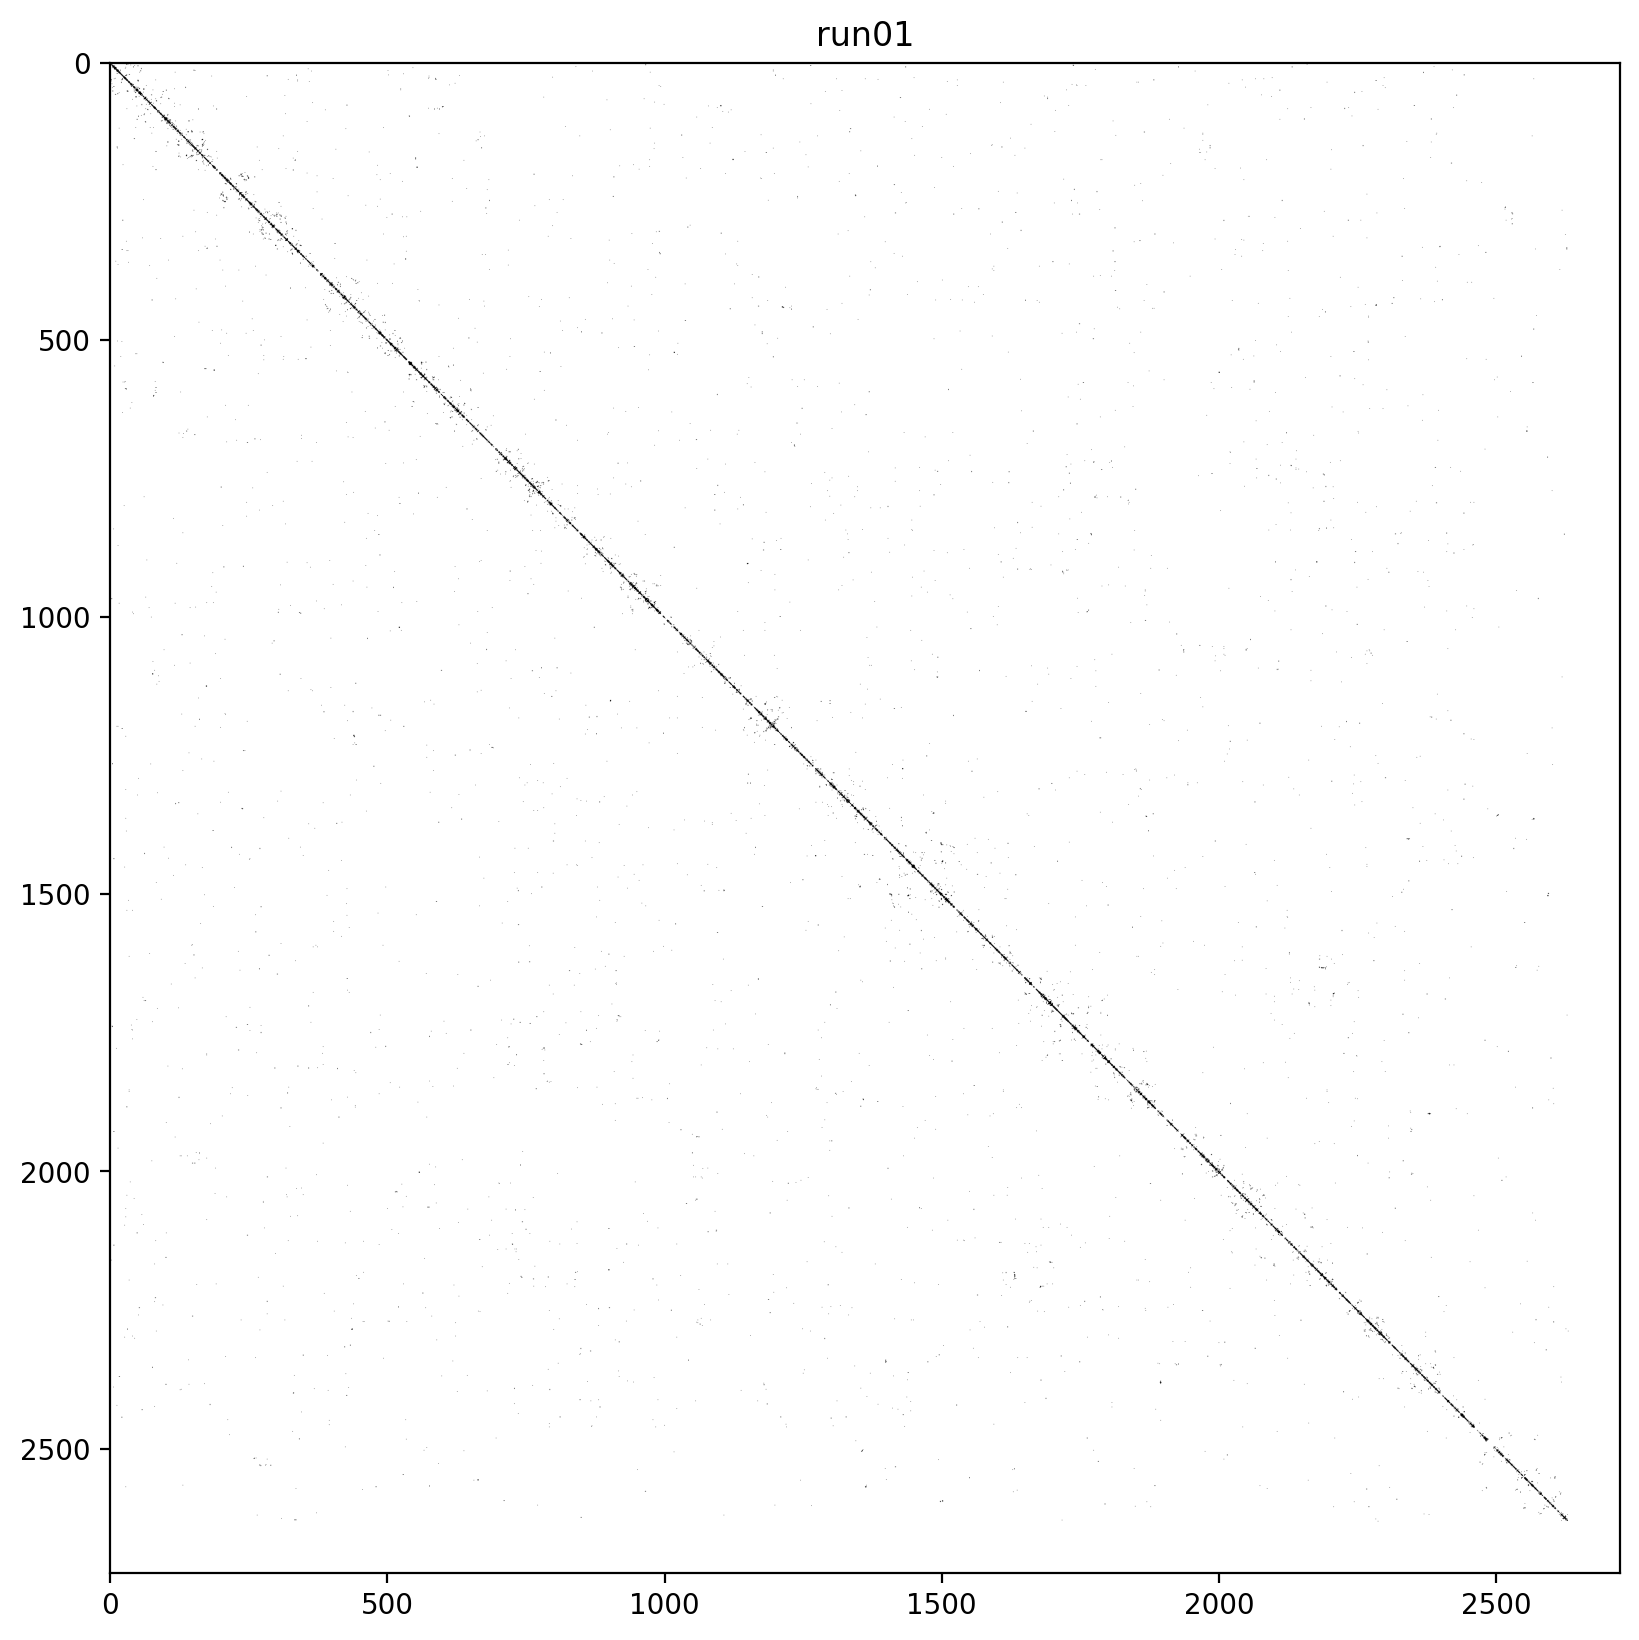

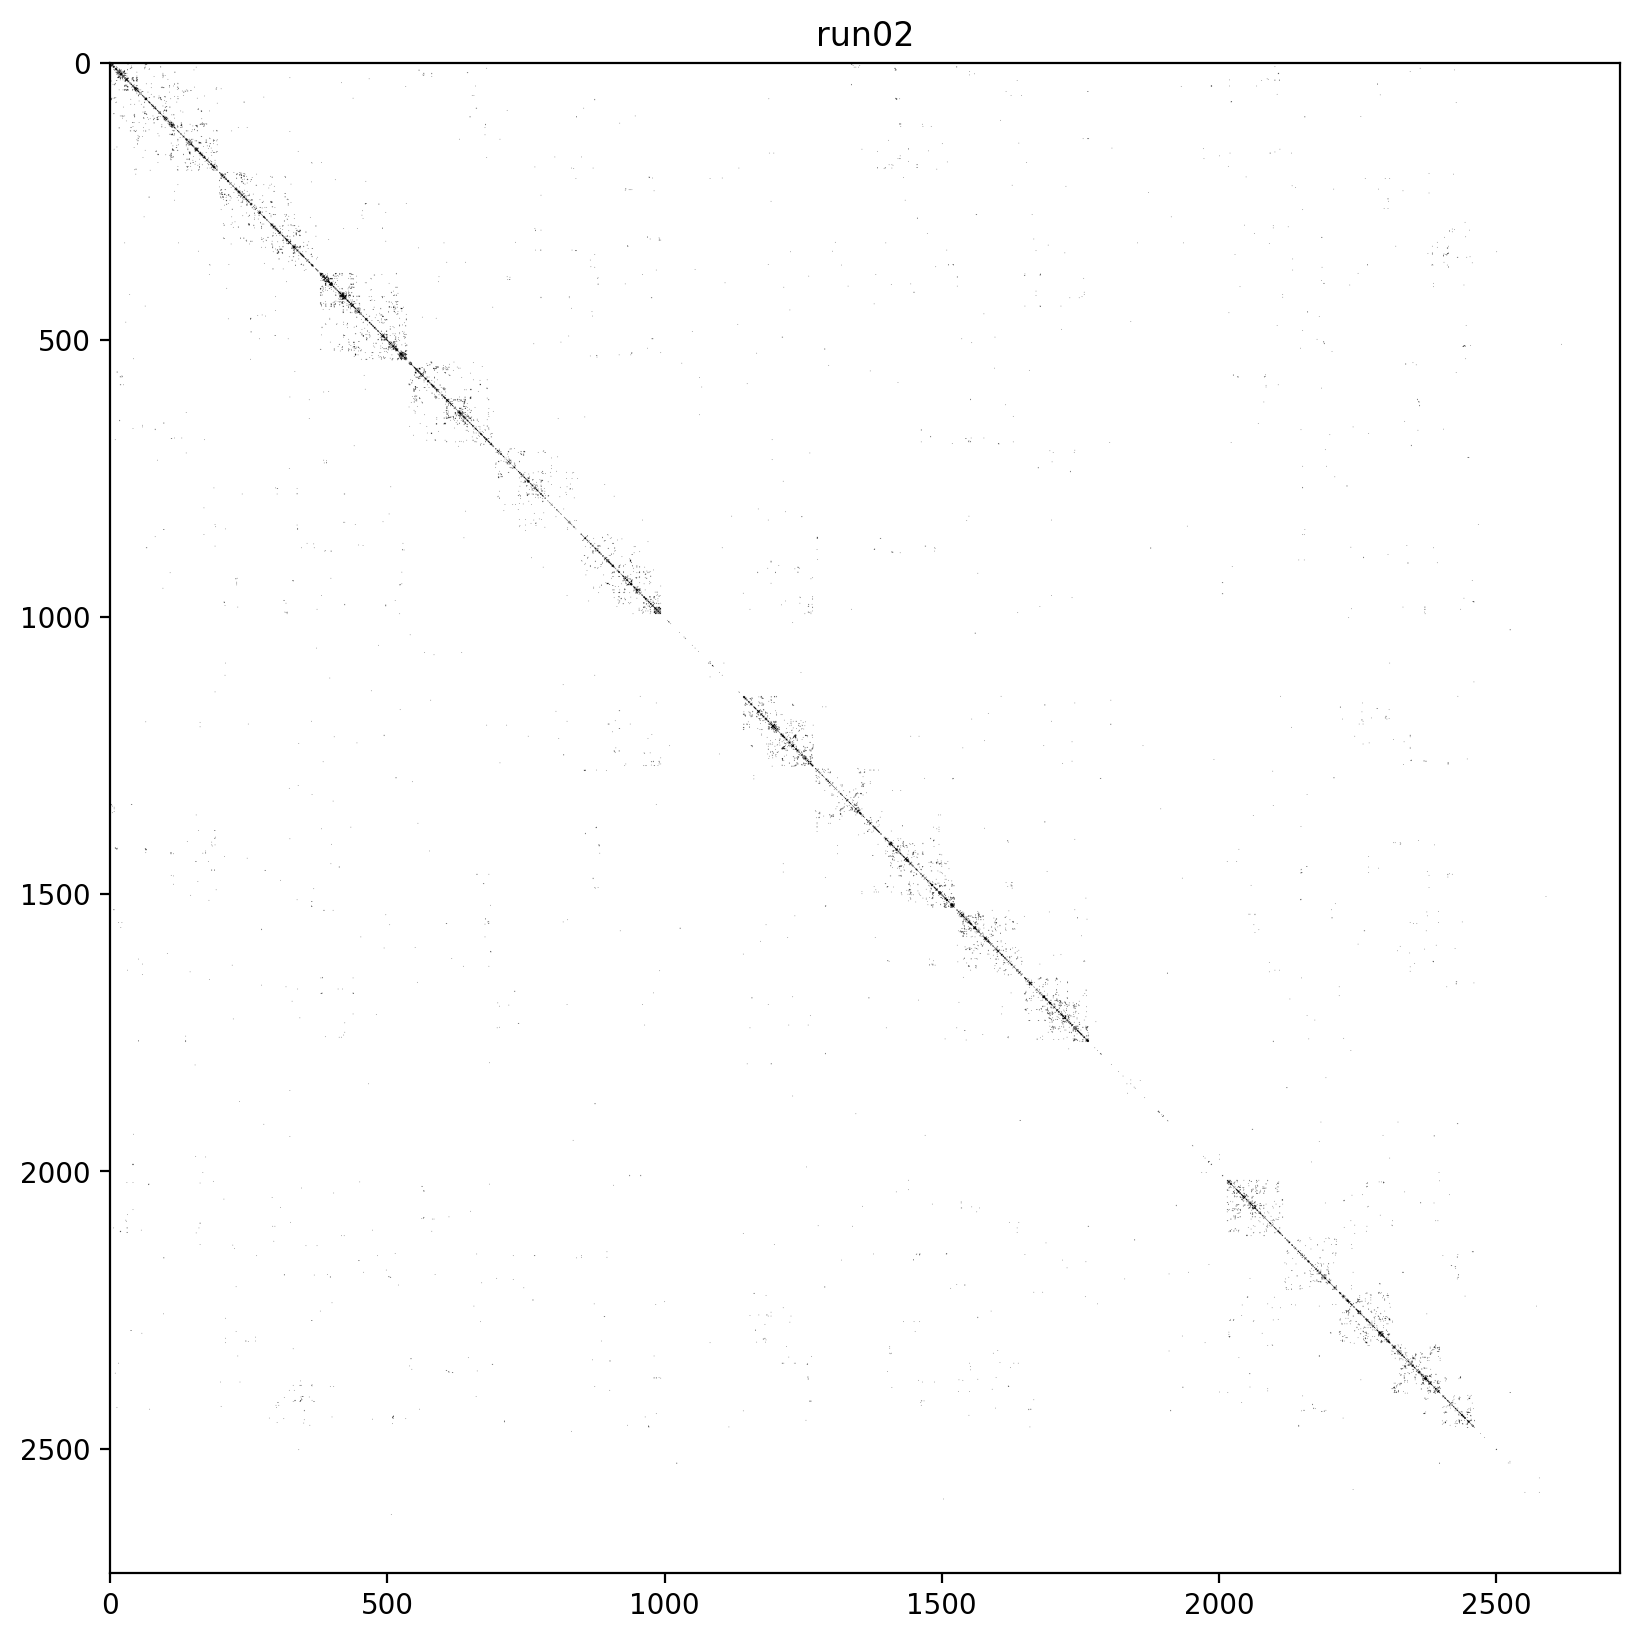

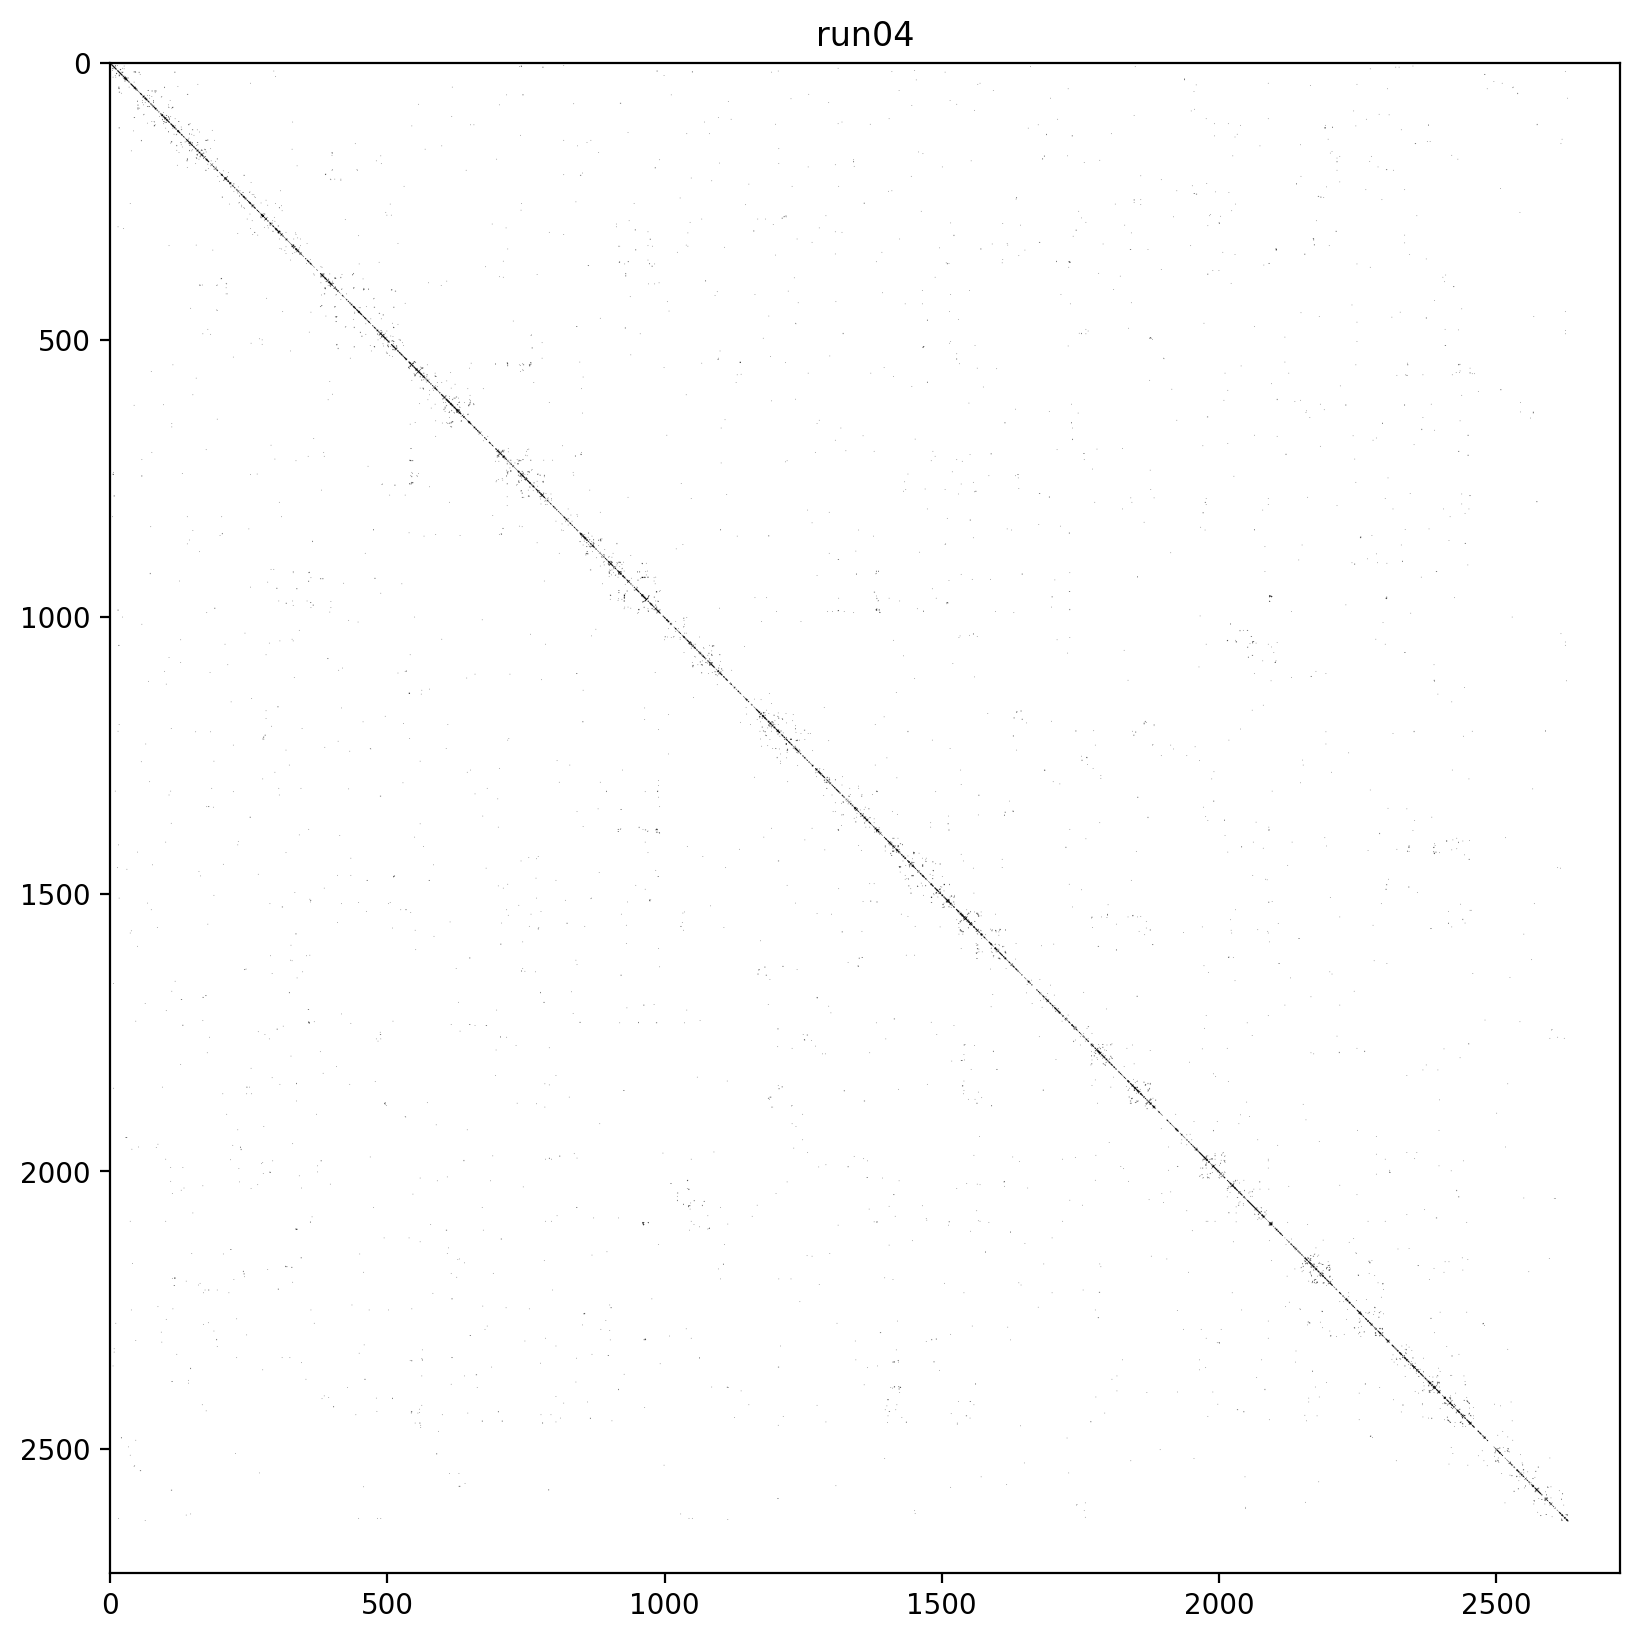

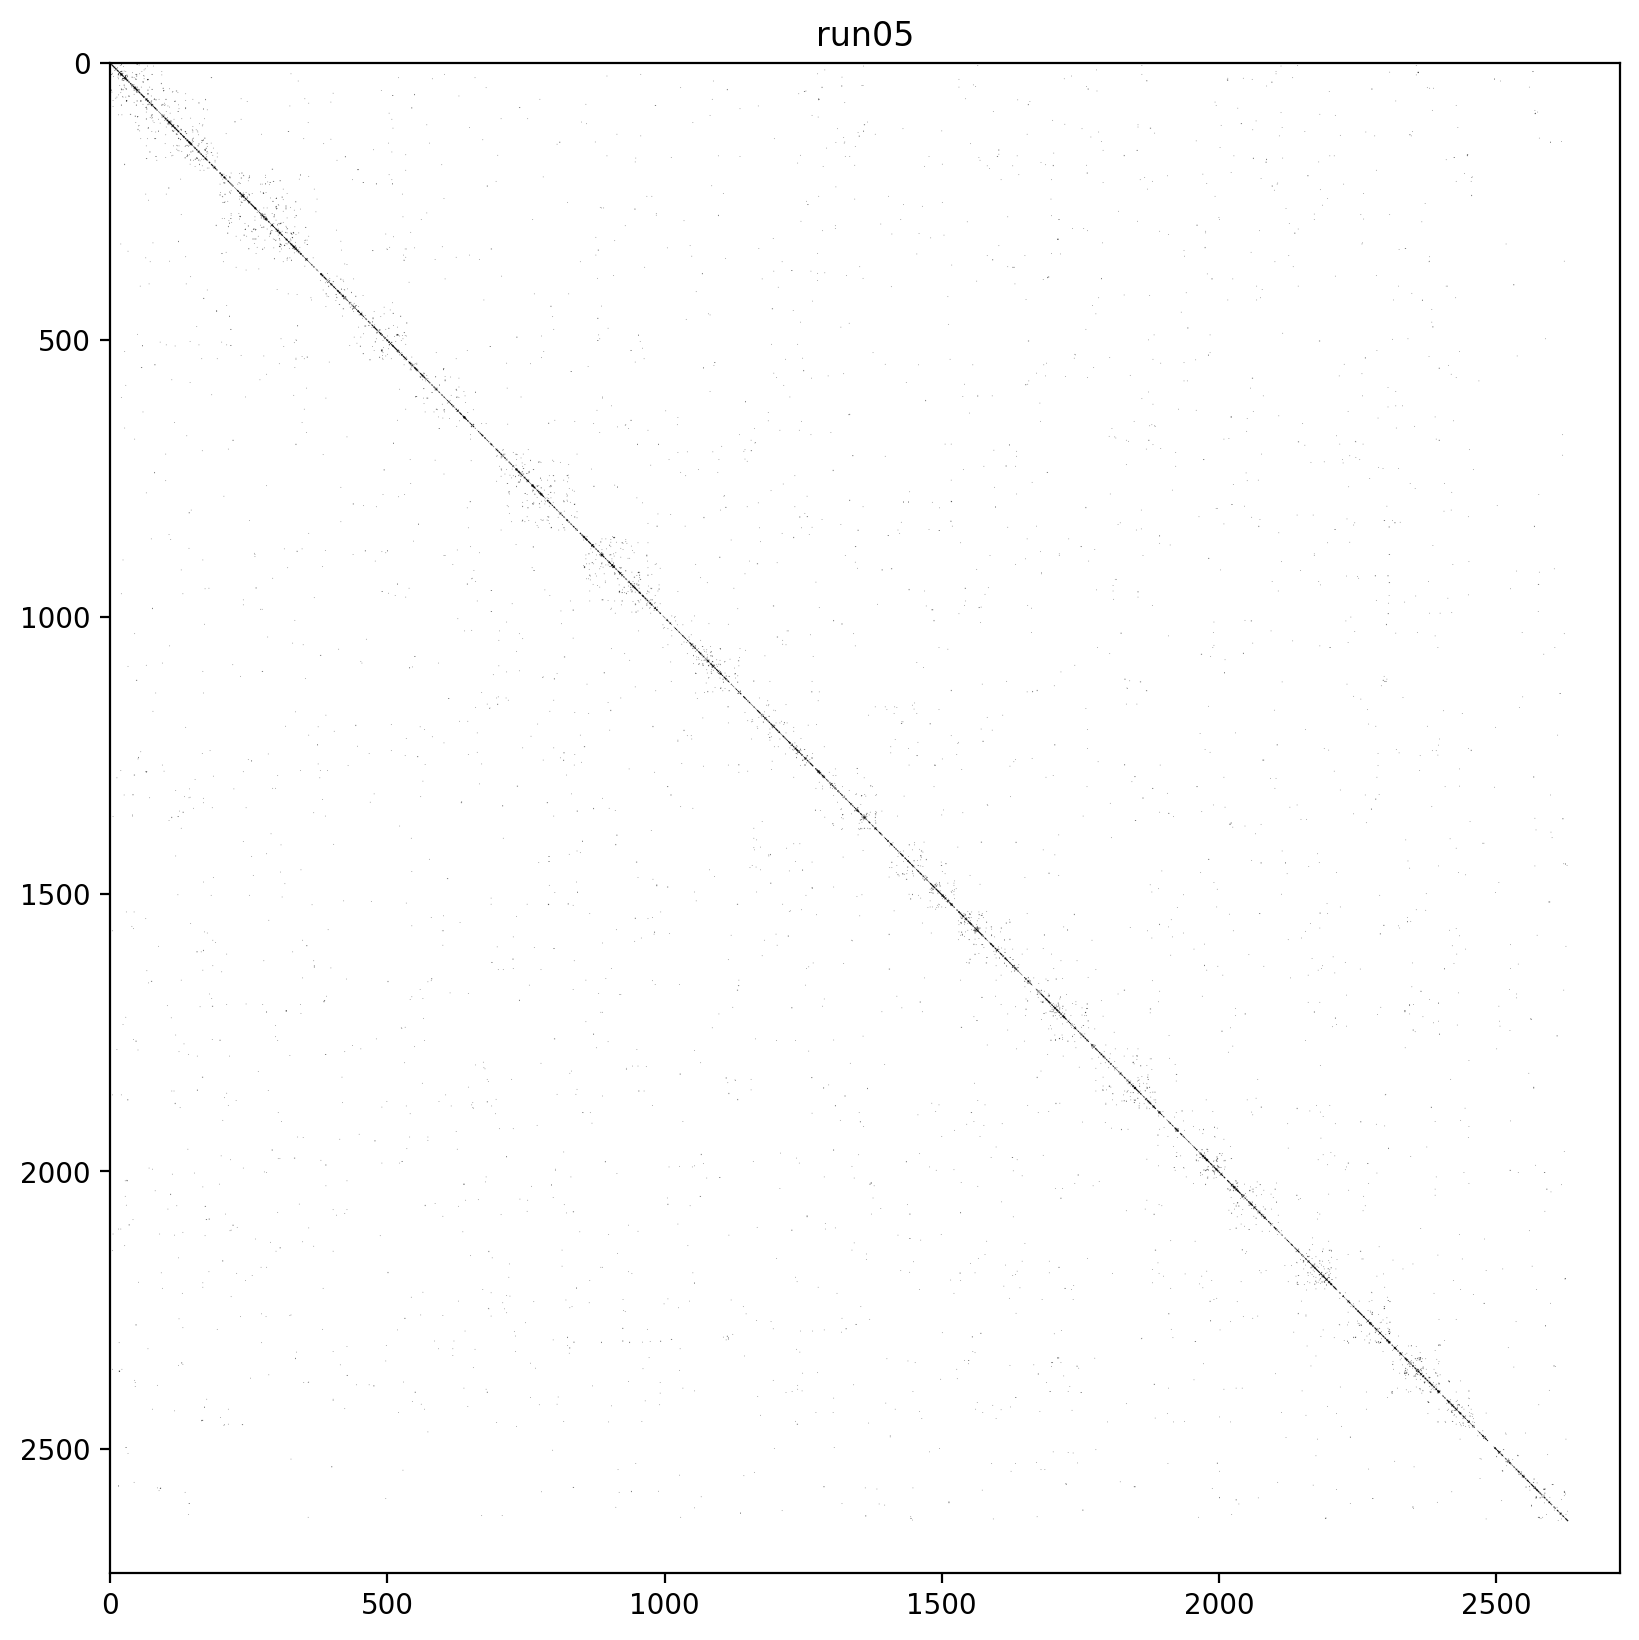

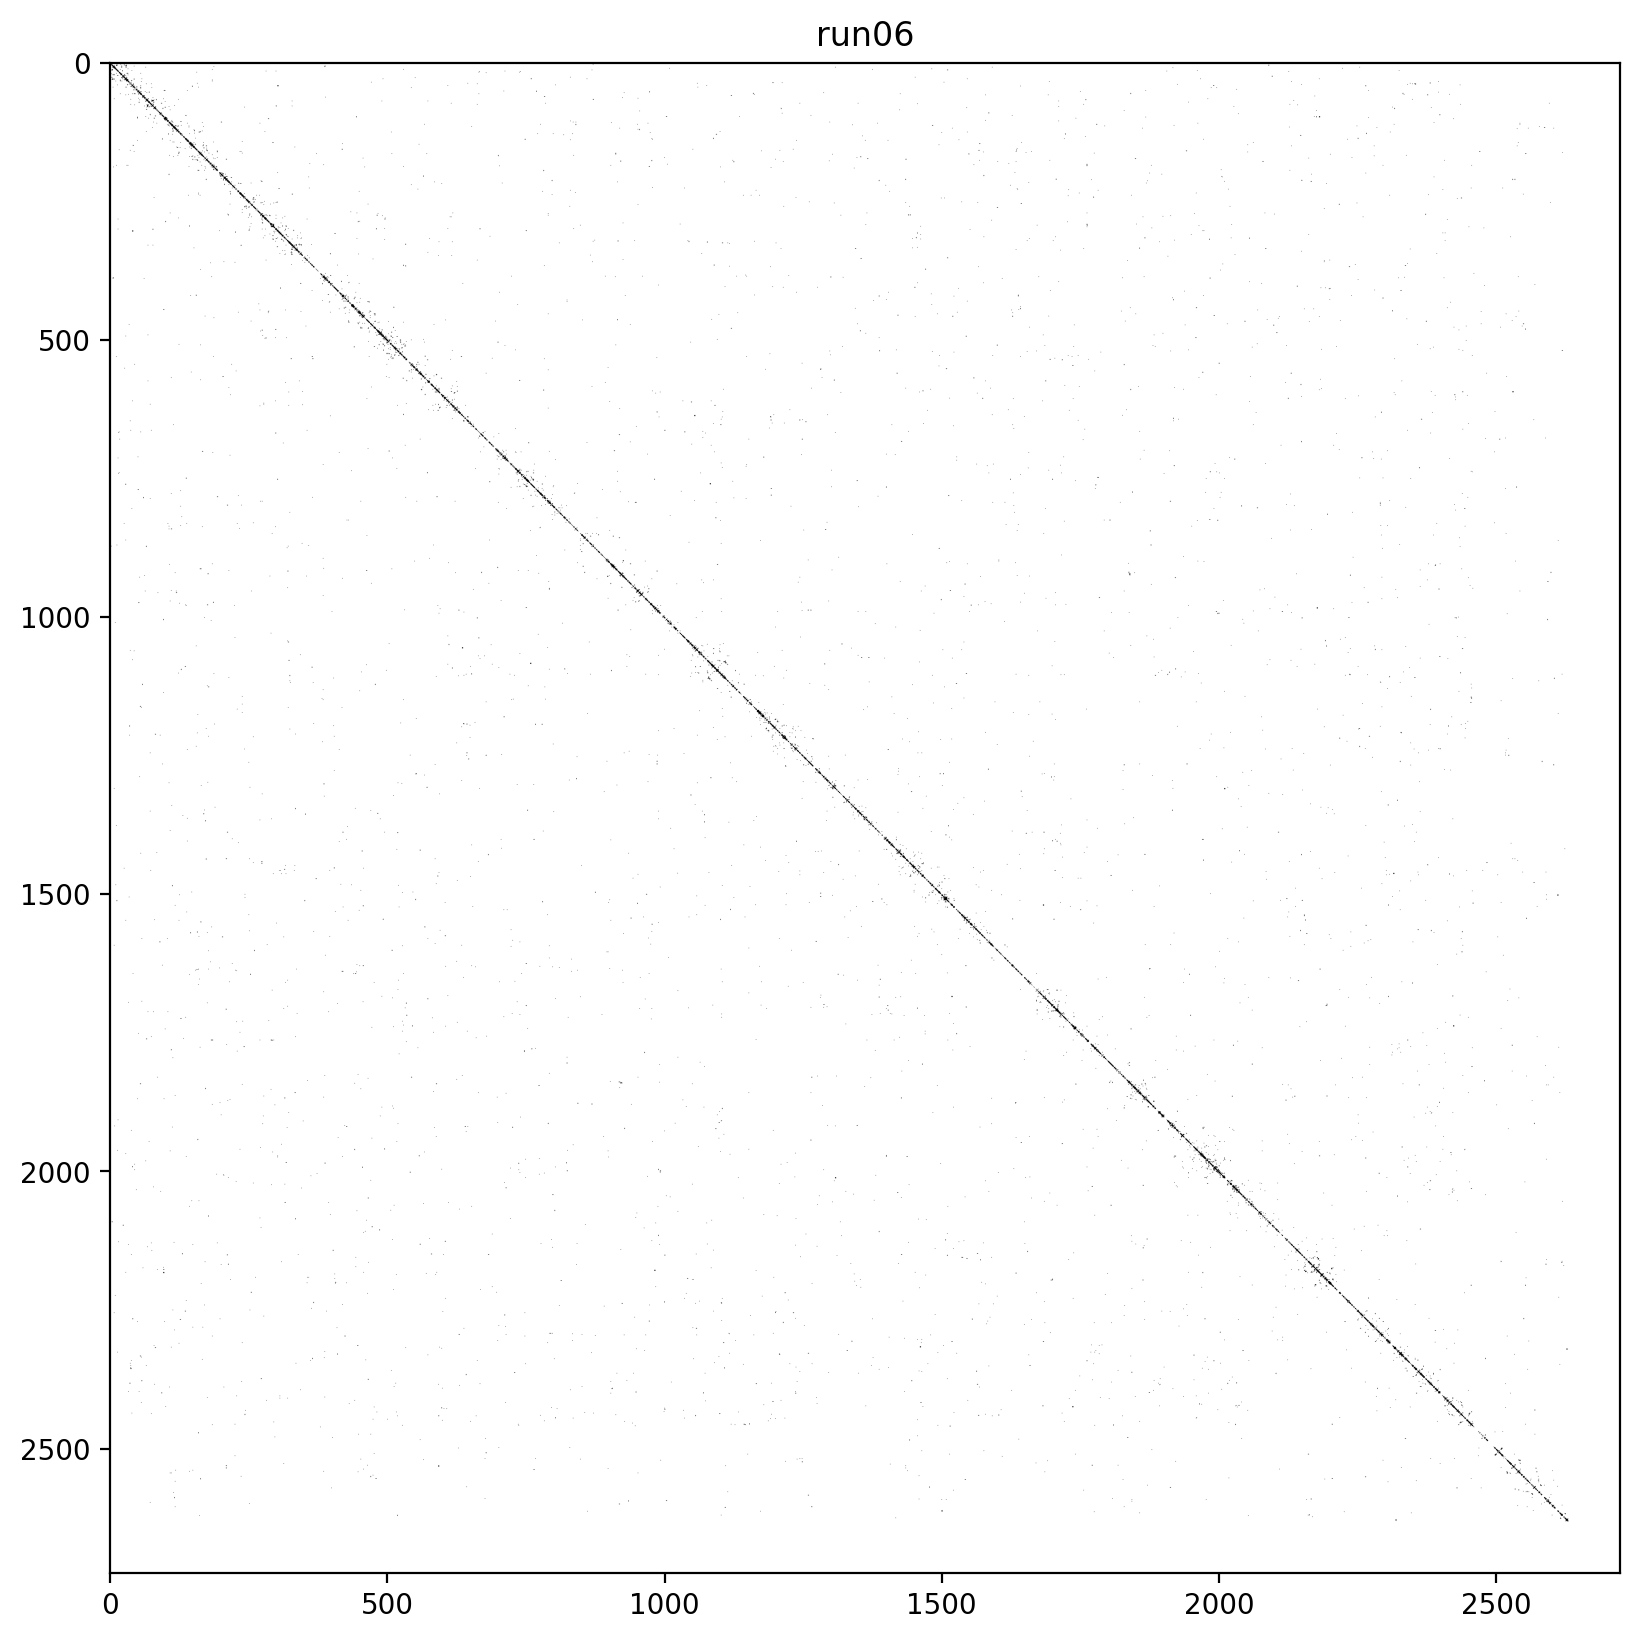

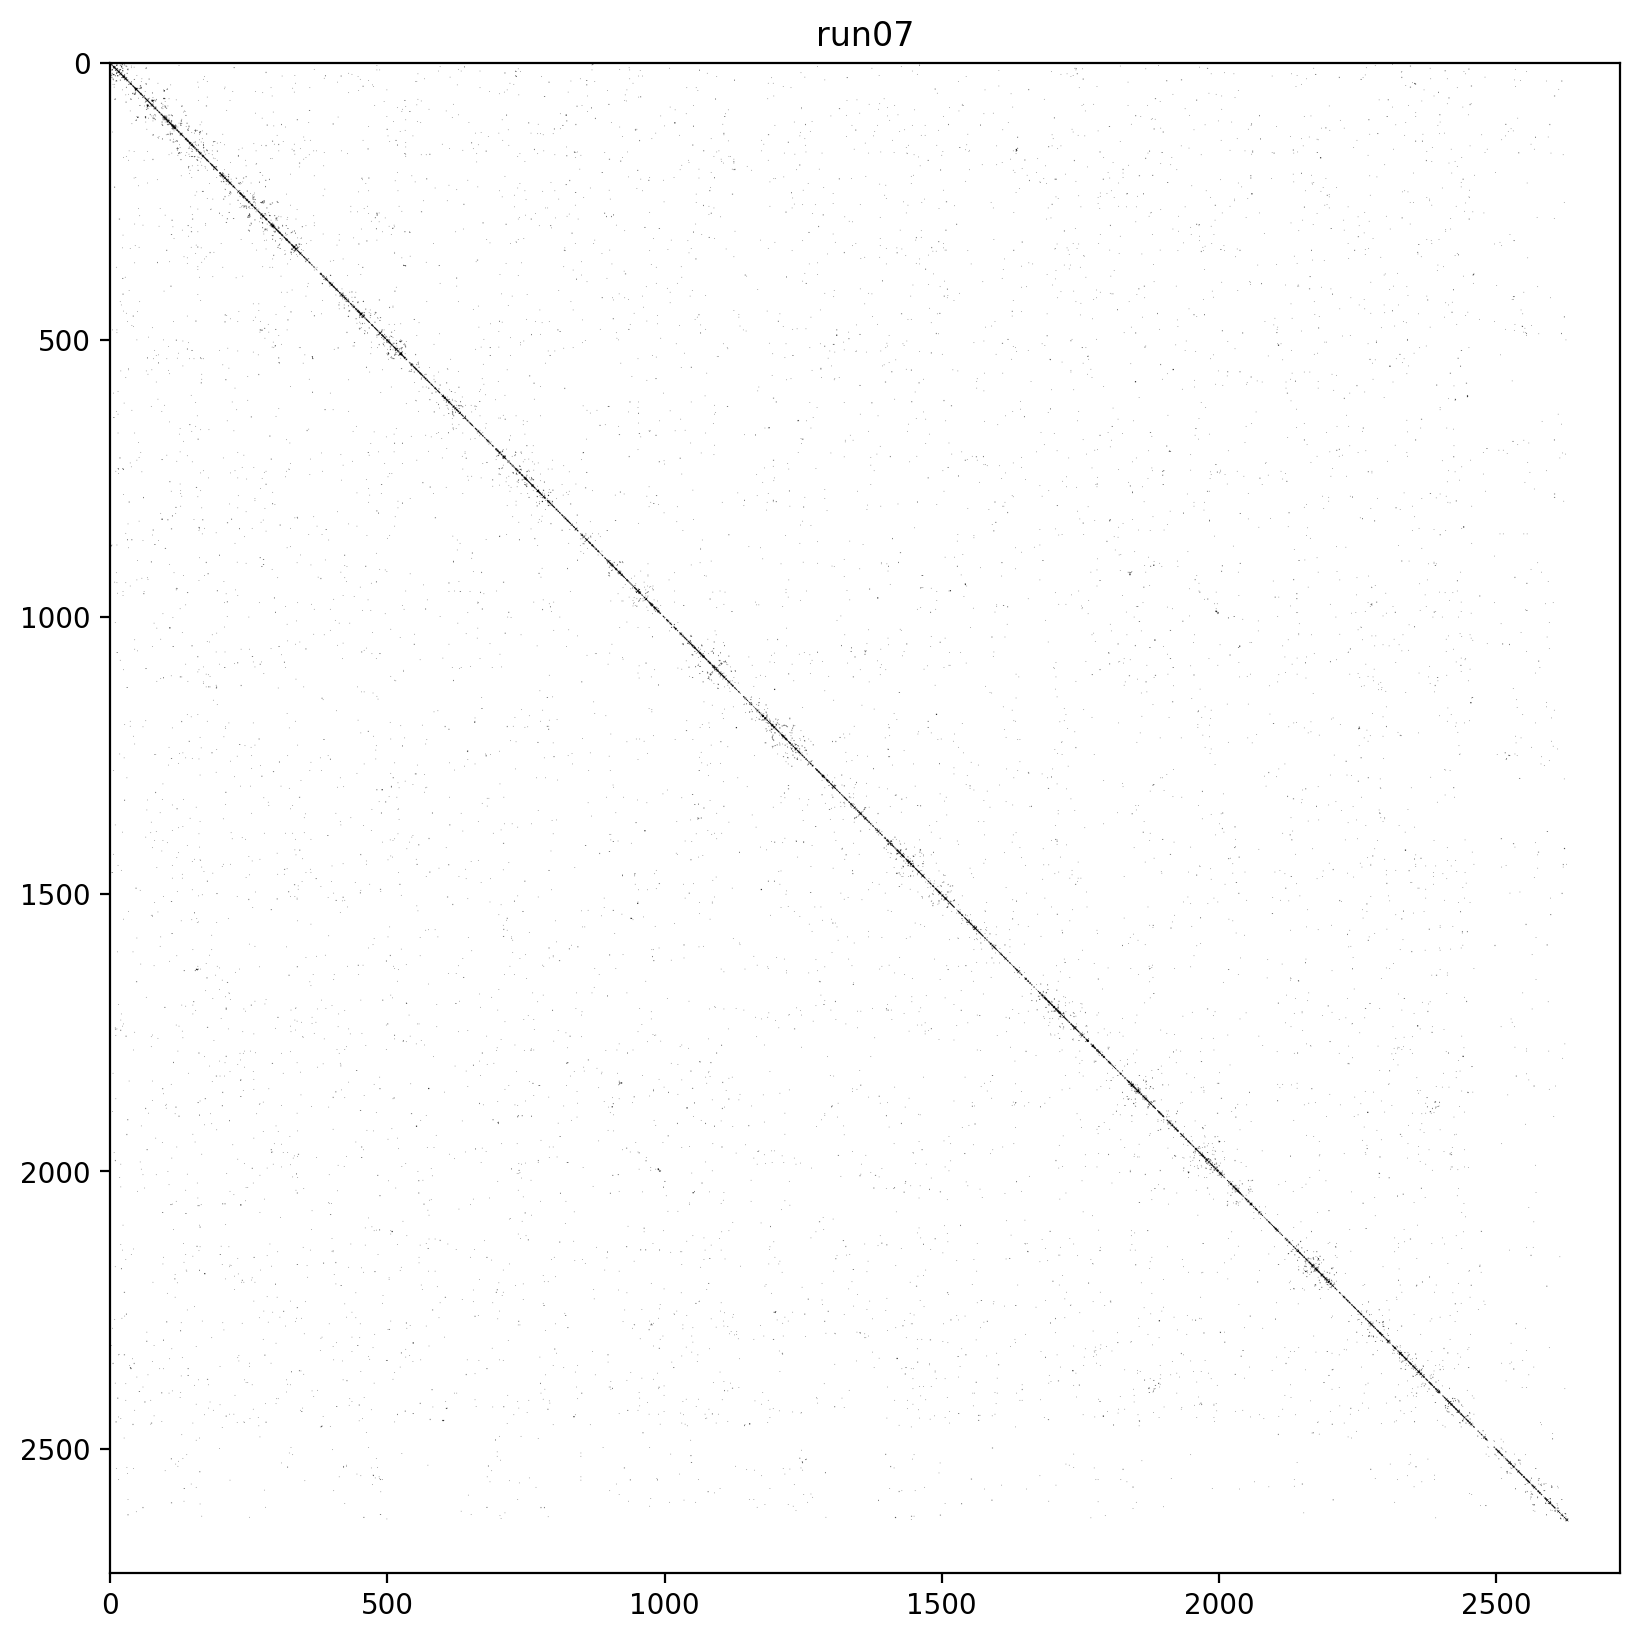

In [95]:
reload(hicPlot)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10
    
for runId, A in matrices.items():
    
    Abinary = np.where(A > 0, 1, 0)
    
    plt.imshow(Abinary, cmap='binary')
    plt.title(runId)
    plt.show()

runId='run01'


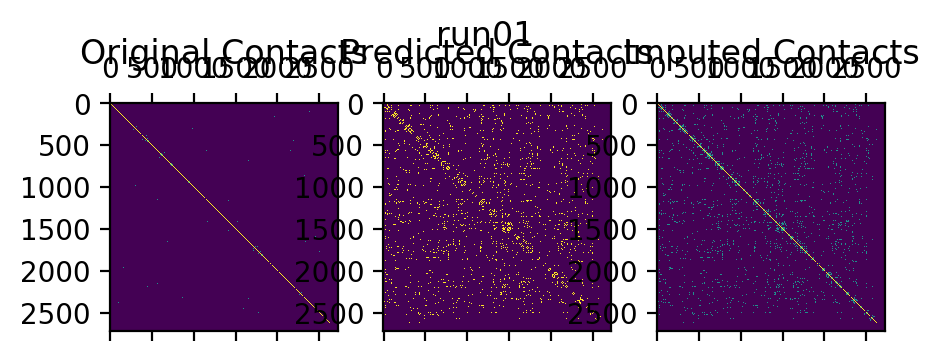

runId='run02'


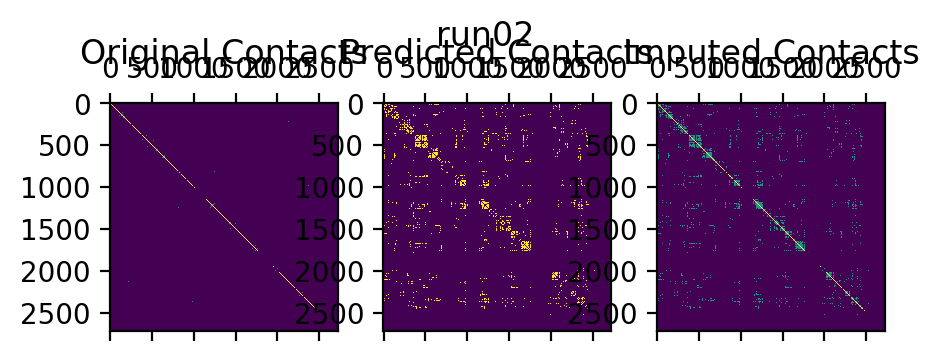

runId='run04'


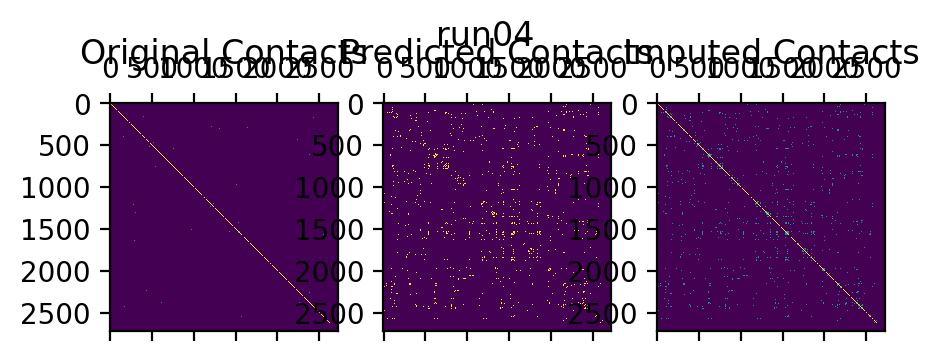

runId='run05'


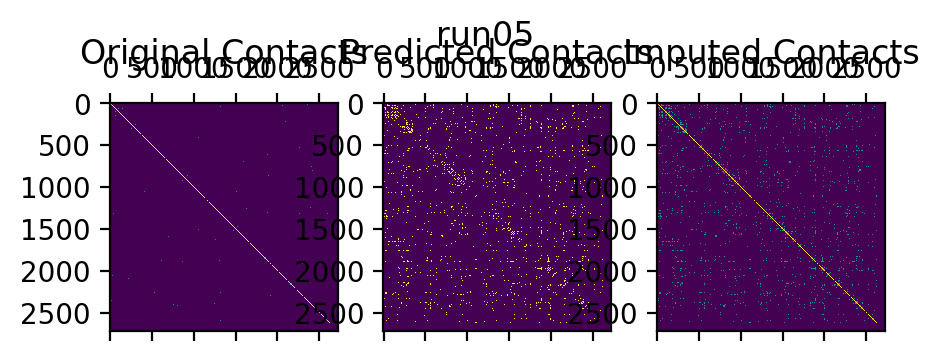

runId='run06'


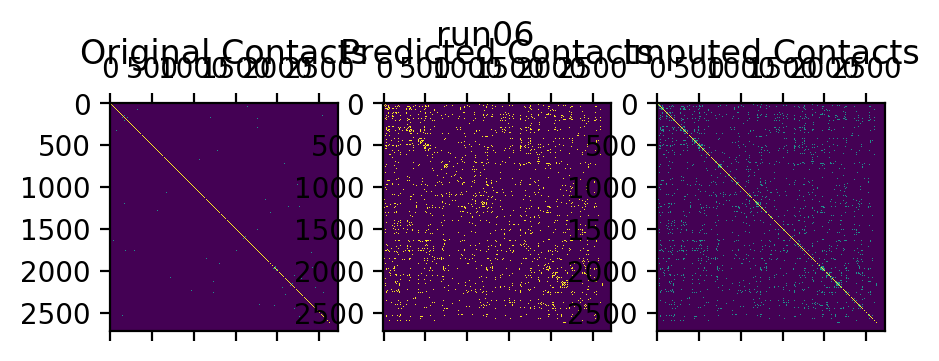

runId='run07'


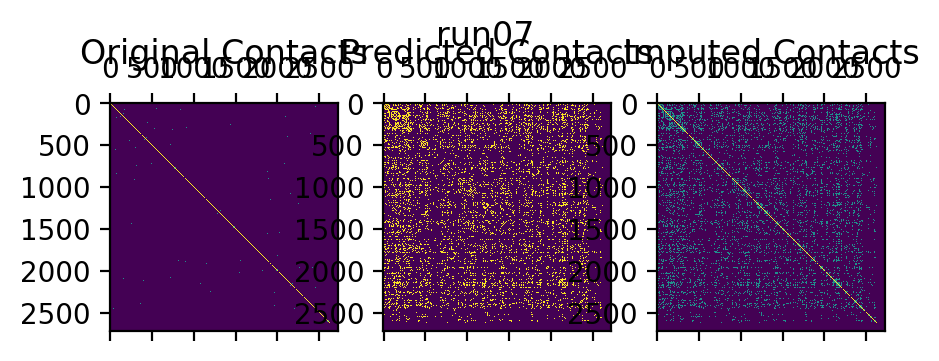

In [40]:
threshold = 0.5

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

imputedContacts = []

for runId, A in matrices.items():
    
    G = nx.from_numpy_array(A)    
    P = np.zeros(A.shape)

    pLink = nx.common_neighbor_centrality(G, alpha=0.1)
    
    for i, j, p in pLink:
        P[i, j] = P[i, j] + p
        P[j, i] = P[j, i] + p
    
    # normalize the link scores
    P = P / P.max()
    
    # threshold based prediction
    P = np.where(P >= threshold, 1, 0)
    
    # impute new contacts
    imputedA = A + P
    imputedContacts.append(imputedA)
    
    fig, ax = plt.subplots(1, 3) 
    
    ax[0].matshow(A)
    ax[0].set_title('Original Contacts', y=1.1)
    
    ax[1].matshow(P)
    ax[1].set_title('Predicted Contacts', y=1.1)
    
    ax[2].matshow(imputedA)
    ax[2].set_title('Imputed Contacts', y=1.1)
    
    plt.suptitle(runId, y=0.7)
    plt.axis(False)
    plt.show()

<ipython-input-41-efa020fe7e8d>:9: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(imputedBulk), cmap='plasma')


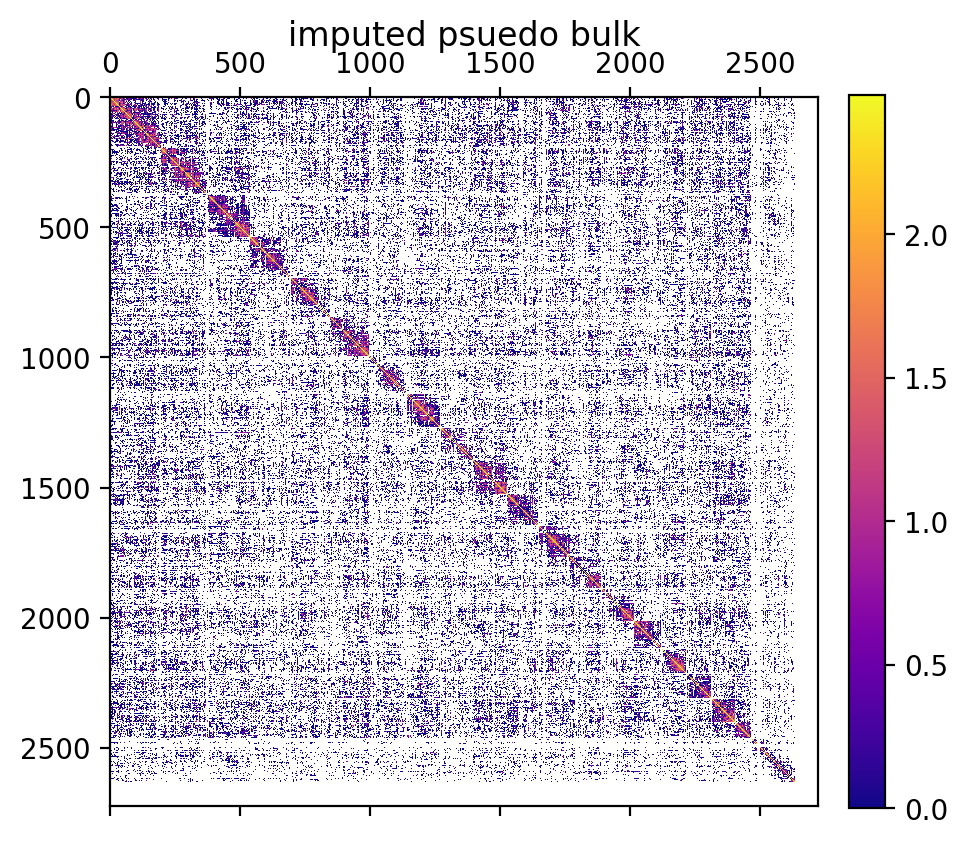

In [41]:
imputedBulk = np.zeros((matrices['run01'].shape))

for imp in imputedContacts:
    imputedBulk += imp

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

plt.matshow(np.log(imputedBulk), cmap='plasma')
plt.title('imputed psuedo bulk')
plt.colorbar(fraction=0.046, pad=0.04)

In [2]:
filepath = f"/nfs/turbo/umms-indikar/shared/projects/poreC/nagano_2017_data/nagano_1MB_raw.scool"
cellList = list(cooler.fileops.list_coolers(filepath))

cellList[:10]

['/Diploid_1_CGTACTAG_AAGGAGTA_R1fastqgz',
 '/Diploid_1_CGTACTAG_ACTGCATA_R1fastqgz',
 '/Diploid_1_CGTACTAG_CGTCTAAT_R1fastqgz',
 '/Diploid_1_CGTACTAG_CTAAGCCT_R1fastqgz',
 '/Diploid_1_CGTACTAG_CTCTCTAT_R1fastqgz',
 '/Diploid_1_CGTACTAG_GTAAGGAG_R1fastqgz',
 '/Diploid_1_CGTACTAG_TATCCTCT_R1fastqgz',
 '/Diploid_1_CGTACTAG_TCTCTCCG_R1fastqgz',
 '/Diploid_1_TAAGGCGA_AAGGAGTA_R1fastqgz',
 '/Diploid_1_TAAGGCGA_CGTCTAAT_R1fastqgz']

In [ ]:
for i, cell in enumerate(cellList[:10]):
    A = clr.matrix(balance=True)[:]
    Abinary = np.where(A > 0, 1, 0)
    plt.imshow(Abinary, cmap='binary')
    plt.title(cell)